In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fetch historical data
ticker = 'AAPL'
data = yf.download(ticker, start='2023-01-01', end='2023-12-31')

[*********************100%%**********************]  1 of 1 completed


In [17]:
# Data Cleaning and Preprocessing
data.fillna(method='ffill', inplace=True)
data.index = pd.to_datetime(data.index)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,130.279999,130.899994,124.169998,125.070000,124.048042,112117500
2023-01-04,126.889999,128.660004,125.080002,126.360001,125.327507,89113600
2023-01-05,127.129997,127.769997,124.760002,125.019997,123.998459,80962700
2023-01-06,126.010002,130.289993,124.889999,129.619995,128.560867,87754700
2023-01-09,130.470001,133.410004,129.889999,130.149994,129.086548,70790800


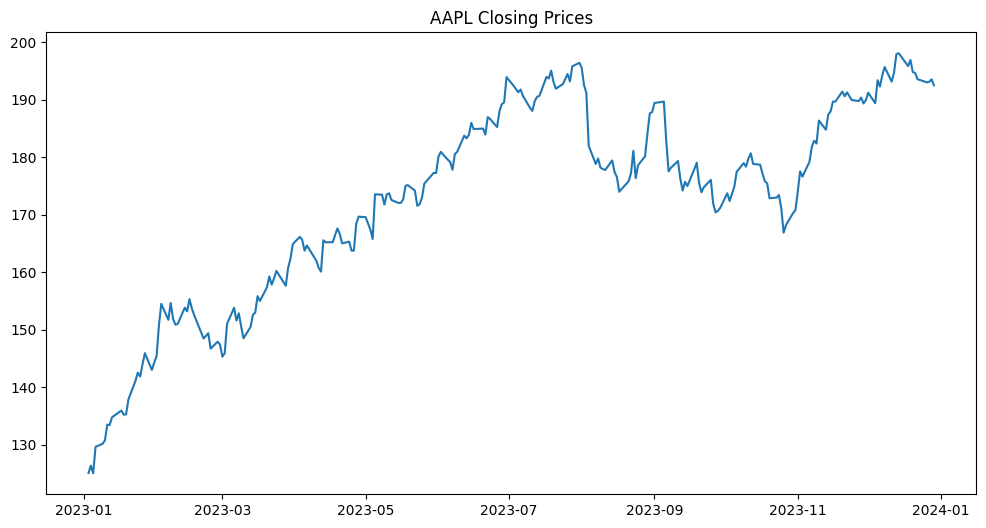

In [18]:
# Initial Exploratory Analysis
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.title('AAPL Closing Prices')
plt.show()

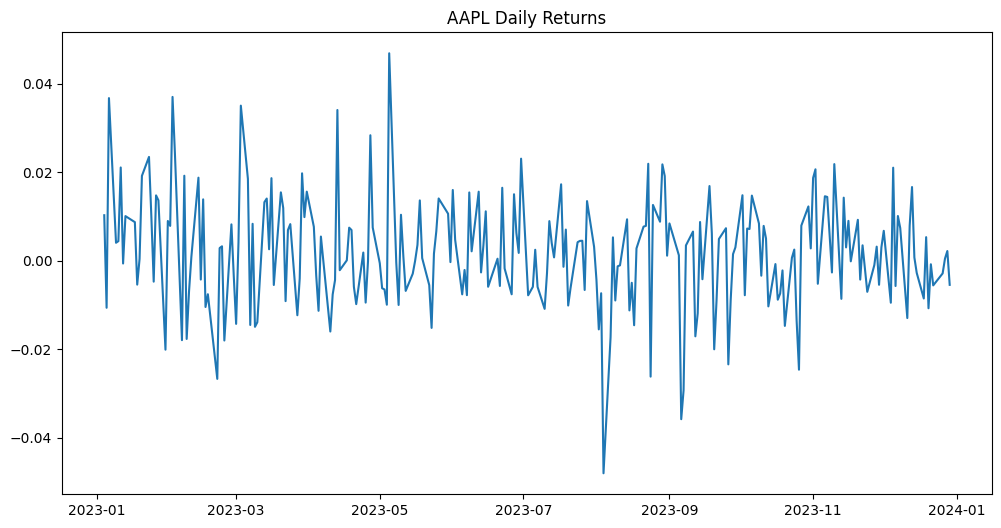

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'].pct_change())
plt.title('AAPL Daily Returns')
plt.show()


             Open        High         Low       Close   Adj Close  \
count  250.000000  250.000000  250.000000  250.000000  250.000000   
mean   172.256681  173.857520  170.981880  172.549000  171.668916   
std     17.530359   17.261055   17.535099   17.331672   17.458136   
min    126.010002  127.769997  124.169998  125.019997  123.998459   
25%    161.555000  162.387501  160.699997  162.112499  161.033356   
50%    175.244995  177.025002  173.840004  175.475006  174.783730   
75%    186.805000  188.095001  185.174995  187.330002  186.686111   
max    198.020004  199.619995  197.000000  198.110001  197.589523   

             Volume  
count  2.500000e+02  
mean   5.921703e+07  
std    1.777392e+07  
min    2.404830e+07  
25%    4.781208e+07  
50%    5.507750e+07  
75%    6.574292e+07  
max    1.543573e+08  


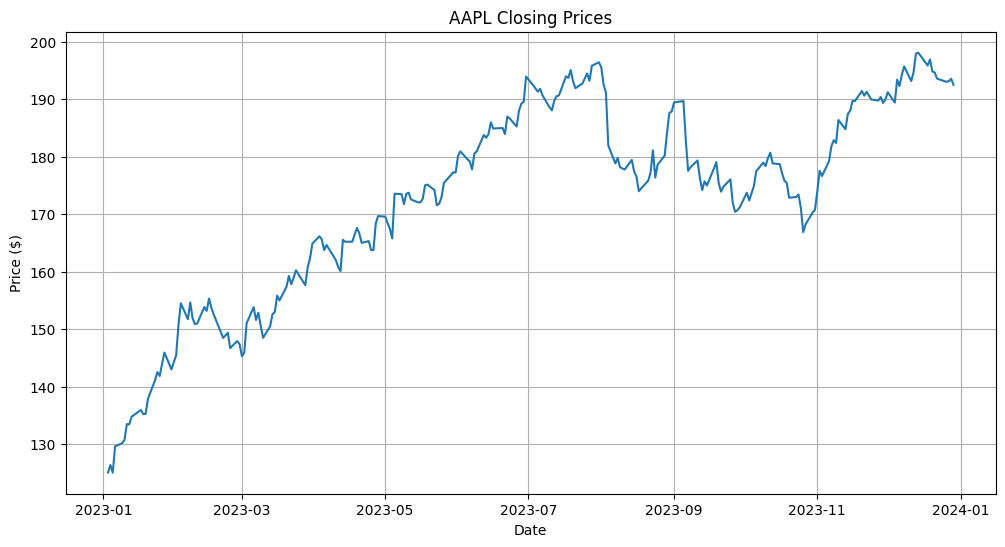

In [20]:
import calendar
print(data.describe())

# Time Series Plot of Closing Prices
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.title('AAPL Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

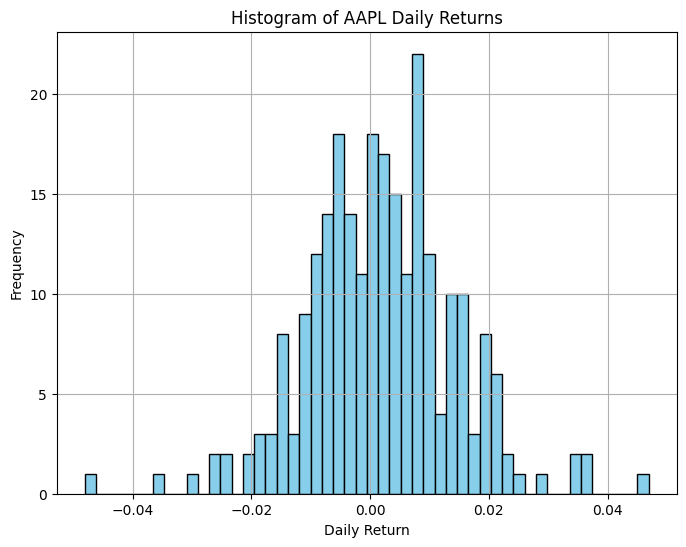

In [21]:
# Histogram of Daily Returns
plt.figure(figsize=(8, 6))
plt.hist(data['Close'].pct_change().dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of AAPL Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

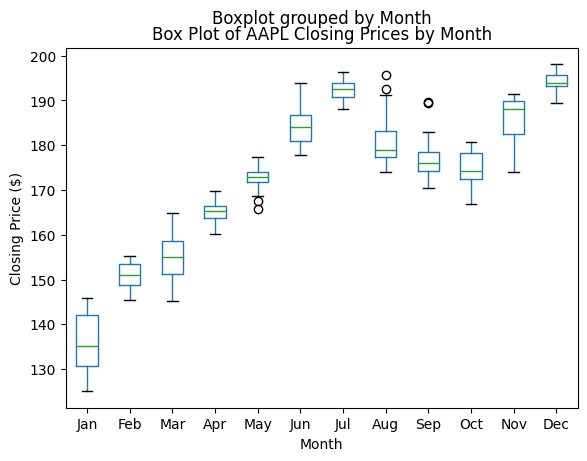

In [22]:
# Box Plot of Closing Prices by Month
data['Month'] = data.index.month
plt.figure(figsize=(12, 6))
data.boxplot(column='Close', by='Month', grid=False)
plt.title('Box Plot of AAPL Closing Prices by Month')
plt.xlabel('Month')
plt.ylabel('Closing Price ($)')
plt.xticks(range(1, 13), calendar.month_abbr[1:13])
plt.show()



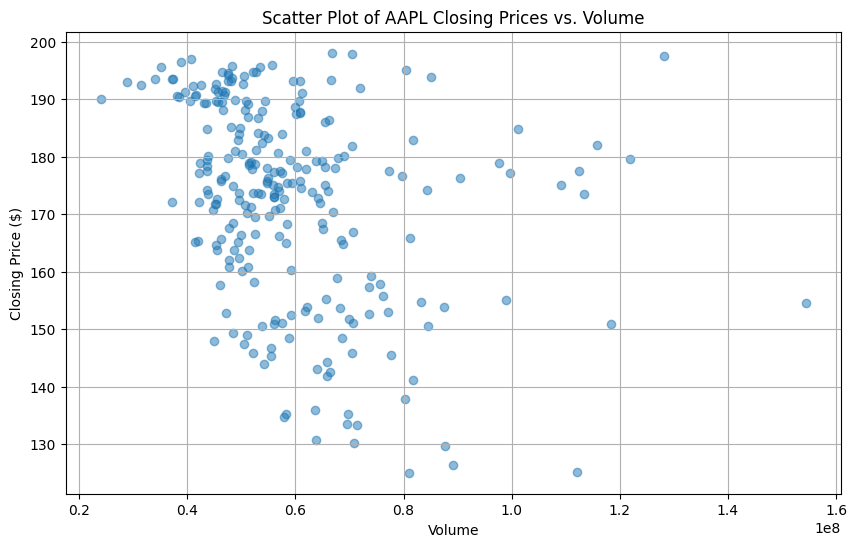

In [23]:
# Scatter Plot of Closing Prices vs. Volume
plt.figure(figsize=(10, 6))
plt.scatter(data['Volume'], data['Close'], alpha=0.5)
plt.title('Scatter Plot of AAPL Closing Prices vs. Volume')
plt.xlabel('Volume')
plt.ylabel('Closing Price ($)')
plt.grid(True)
plt.show()

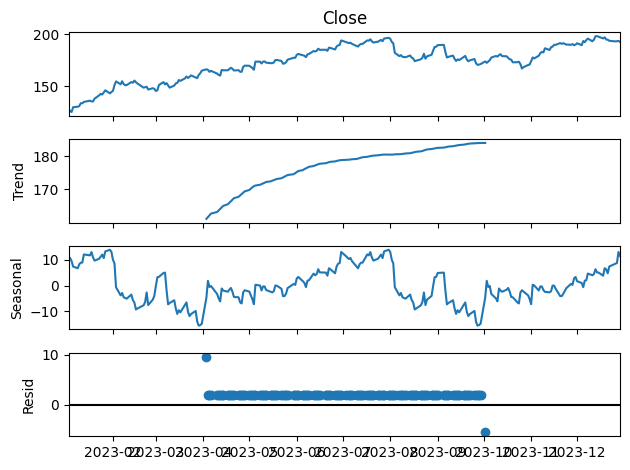

In [24]:
# Seasonal Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Adjust the period parameter
period = 125  # Approximating half the number of trading days in a year
decomposition = seasonal_decompose(data['Close'], model='additive', period=period)
decomposition.plot()
plt.show()


In [25]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(data['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Check for stationarity
if result[1] > 0.05:
    print('ADF test indicates that the data is not stationary.')
else:
    print('ADF test indicates that the data is stationary.')

# If the data is not stationary, apply transformations
if result[1] > 0.05:
    # Apply transformations here, such as differencing or log transformation
    # Example: Differencing
    data['Close_diff'] = data['Close'].diff()
    # Re-run the ADF test on the transformed data
    result_diff = adfuller(data['Close_diff'].dropna())
    print('\nAfter differencing:')
    print('ADF Statistic:', result_diff[0])
    print('p-value:', result_diff[1])
    print('Critical Values:', result_diff[4])


ADF Statistic: -2.60347300088481
p-value: 0.09228159120356583
Critical Values: {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}
ADF test indicates that the data is not stationary.

After differencing:
ADF Statistic: -14.744057983380218
p-value: 2.5443509763814487e-27
Critical Values: {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}


In [26]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Prepare data for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60  # Define the sequence length
X, y = create_sequences(scaled_data, seq_length)

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to be 3D [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM model
model.fit(X_train, y_train, epochs=300, batch_size=32, verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Inverse transform the actual values
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


Epoch 1/300
5/5 [==============================] - 4s 11ms/step - loss: 0.4257
Epoch 2/300
5/5 [==============================] - 0s 10ms/step - loss: 0.0484
Epoch 3/300
5/5 [==============================] - 0s 10ms/step - loss: 0.0422
Epoch 4/300
5/5 [==============================] - 0s 9ms/step - loss: 0.0161
Epoch 5/300
5/5 [==============================] - 0s 9ms/step - loss: 0.0220
Epoch 6/300
5/5 [==============================] - 0s 9ms/step - loss: 0.0074
Epoch 7/300
5/5 [==============================] - 0s 10ms/step - loss: 0.0090
Epoch 8/300
5/5 [==============================] - 0s 8ms/step - loss: 0.0060
Epoch 9/300
5/5 [==============================] - 0s 9ms/step - loss: 0.0056
Epoch 10/300
5/5 [==============================] - 0s 8ms/step - loss: 0.0059
Epoch 11/300
5/5 [==============================] - 0s 8ms/step - loss: 0.0049
Epoch 12/300
5/5 [==============================] - 0s 10ms/step - loss: 0.0052
Epoch 13/300
5/5 [==============================] - 0s 8

In [27]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Calculate MAE
train_mae = mean_absolute_error(y_train[0], train_predict[:,0])
test_mae = mean_absolute_error(y_test[0], test_predict[:,0])

# Calculate MAPE
train_mape = mean_absolute_percentage_error(y_train[0], train_predict[:,0])
test_mape = mean_absolute_percentage_error(y_test[0], test_predict[:,0])

# Calculate R2 Score
train_r2 = r2_score(y_train[0], train_predict[:,0])
test_r2 = r2_score(y_test[0], test_predict[:,0])

print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')
print(f'Train MAPE: {train_mape}')
print(f'Test MAPE: {test_mape}')
print(f'Train R2 Score: {train_r2}')
print(f'Test R2 Score: {test_r2}')


Train MAE: 2.0052009381745983
Test MAE: 1.6682152999074806
Train MAPE: 0.011381613471428327
Test MAPE: 0.008736845100620217
Train R2 Score: 0.9178852557510445
Test R2 Score: 0.7968000241195132


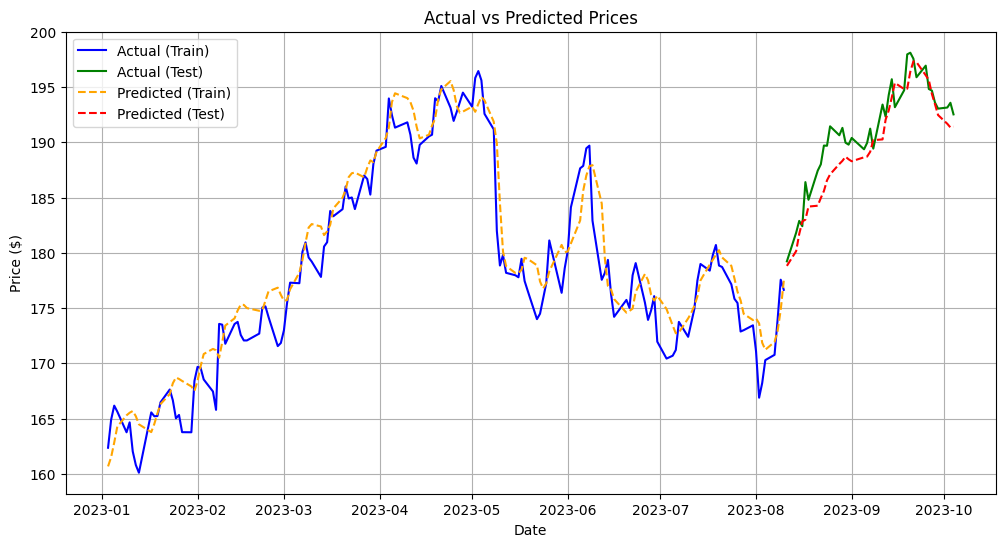

In [28]:
import matplotlib.pyplot as plt

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(data.index[:len(train_predict)], y_train[0], label='Actual (Train)', color='blue')
plt.plot(data.index[len(train_predict):len(train_predict)+len(test_predict)], y_test[0], label='Actual (Test)', color='green')
plt.plot(data.index[:len(train_predict)], train_predict[:,0], label='Predicted (Train)', linestyle='--', color='orange')
plt.plot(data.index[len(train_predict):len(train_predict)+len(test_predict)], test_predict[:,0], label='Predicted (Test)', linestyle='--', color='red')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()




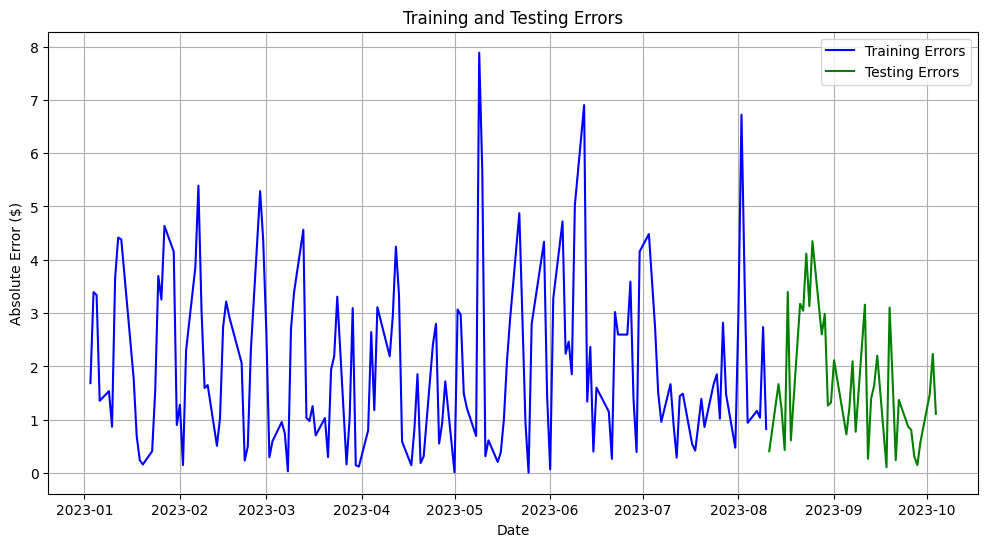

In [29]:
# Plot training and testing errors
train_errors = np.abs(y_train[0] - train_predict[:,0])
test_errors = np.abs(y_test[0] - test_predict[:,0])

plt.figure(figsize=(12, 6))
plt.plot(data.index[:len(train_predict)], train_errors, label='Training Errors', color='blue')
plt.plot(data.index[len(train_predict):len(train_predict)+len(test_predict)], test_errors, label='Testing Errors', color='green')
plt.title('Training and Testing Errors')
plt.xlabel('Date')
plt.ylabel('Absolute Error ($)')
plt.legend()
plt.grid(True)
plt.show()